## Multi-Document Agentic RAG

This example provides a comprehensive guide on creating a Multi-Document Agentic RAG leveraging the power of Embeddings and VectorDB. We'll explore how we can use Reasoning + Acting (ReAct) strategy to harness our RAG setup and make it more intelligent using different tools.

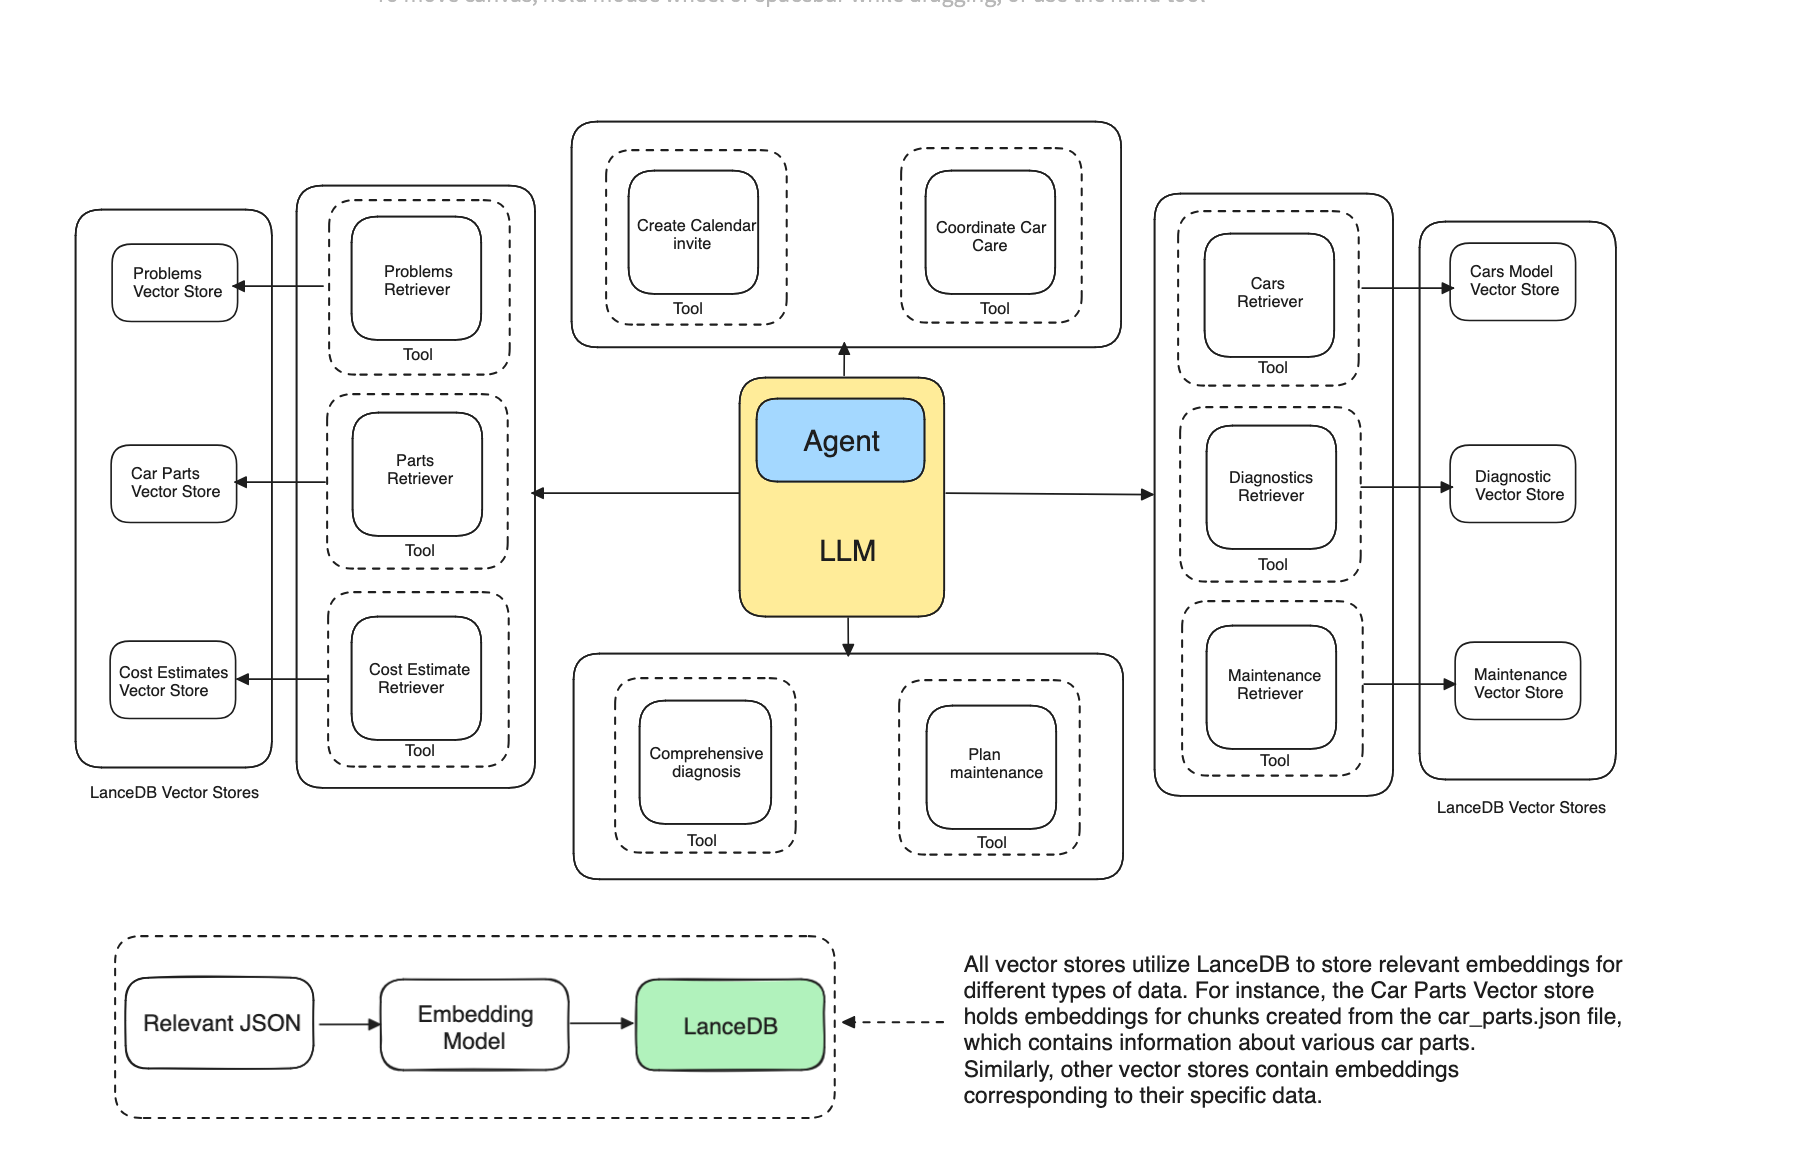

### Run setup: Setting up Environment and other configuration


In [2]:
!pip install llama_index llama-index-vector-stores-lancedb llama-index-embeddings-huggingface lancedb -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.4/27.4 MB 17.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.5/30.5 MB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 33.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 30.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 54.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 195.8/195.8 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 298.0/298.0 kB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 32.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 2.5 MB/s eta 0:00:00


In [3]:
import os
import tqdm
import json
import time
from typing import List, Optional, Dict, Any
from tqdm import tqdm
import logging
from llama_index.core import (
    SimpleDirectoryReader,
    VectorStoreIndex,
    StorageContext,
    Settings,
    Document,
)
from datetime import datetime, timedelta
from llama_index.core.node_parser import SentenceSplitter
from llama_index.vector_stores.lancedb import LanceDBVectorStore
from llama_index.llms.openai import OpenAI
from llama_index.embeddings.huggingface import HuggingFaceEmbedding
from llama_index.core.tools import FunctionTool, ToolOutput
from llama_index.core.retrievers import VectorIndexRetriever
from llama_index.core.agent import FunctionCallingAgentWorker
from llama_index.core.agent import AgentRunner

In [4]:
import os

# os.environ["TOKENIZERS_PARALLELISM"] = "false"
os.environ["OPENAI_API_KEY"] = "sk-proj-...."

# LLM setup
llm = OpenAI()

# Embedding model setup
embed_model = HuggingFaceEmbedding(model_name="sentence-transformers/all-MiniLM-L6-v2")

# Update the Settings with the new embedding model
Settings.embed_model = embed_model
Settings.chunk_size = 512

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

### Creating relevant Vector Store

We are going to create different lancedb vector stores, each associated with a specific table in a local database (`./lancedb`). The tables store data related to different aspects of automotive data, which is defined in our json files,  such as problems, parts, diagnostics, cost estimates, and maintenance schedules.

In [5]:
# Vector store setup
problems_vector_store = LanceDBVectorStore(
    uri="./lancedb",
    table_name="problems_table",
    mode="overwrite",
)

parts_vector_store = LanceDBVectorStore(
    uri="./lancedb",
    table_name="parts_table",
    mode="overwrite",
)

diagnostics_vector_store = LanceDBVectorStore(
    uri="./lancedb",
    table_name="diagnostics_table",
    mode="overwrite",
)

cost_estimates_vector_store = LanceDBVectorStore(
    uri="./lancedb",
    table_name="cost_estimates_table",
    mode="overwrite",
)

maintenance_schedules_vector_store = LanceDBVectorStore(
    uri="./lancedb",
    table_name="maintenance_schedules_table",
    mode="overwrite",
)

cars_vector_store = LanceDBVectorStore(
    uri="./lancedb",
    table_name="car_maintenance_table",
    mode="overwrite",
)

### Create the retrievers objects

Retrievers objects are python objects that are used to retrieve the relevant data from the database. Each retriever is specific to the type of data that we want to retrieve.

In [6]:
# download json files to use them as dataset

!wget https://raw.githubusercontent.com/lancedb/vectordb-recipes/main/examples/multi-document-agentic-rag/json_files/cars_models.json
!wget https://raw.githubusercontent.com/lancedb/vectordb-recipes/main/examples/multi-document-agentic-rag/json_files/cost_estimates.json
!wget https://raw.githubusercontent.com/lancedb/vectordb-recipes/main/examples/multi-document-agentic-rag/json_files/diagnostics.json
!wget https://raw.githubusercontent.com/lancedb/vectordb-recipes/main/examples/multi-document-agentic-rag/json_files/maintenance.json
!wget https://raw.githubusercontent.com/lancedb/vectordb-recipes/main/examples/multi-document-agentic-rag/json_files/parts.json
!wget https://raw.githubusercontent.com/lancedb/vectordb-recipes/main/examples/multi-document-agentic-rag/json_files/problems.json

--2024-12-04 19:27:22--  https://raw.githubusercontent.com/lancedb/vectordb-recipes/main/examples/multi-document-agentic-rag/json_files/cars_models.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13237 (13K) [text/plain]
Saving to: ‘cars_models.json’

cars_models.json    100%[===================>]  12.93K  --.-KB/s    in 0.001s  

2024-12-04 19:27:22 (22.7 MB/s) - ‘cars_models.json’ saved [13237/13237]

--2024-12-04 19:27:22--  https://raw.githubusercontent.com/lancedb/vectordb-recipes/main/examples/multi-document-agentic-rag/json_files/cost_estimates.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.10

In [7]:
def load_and_index_document_from_file(
    file_path: str, vector_store: LanceDBVectorStore
) -> VectorStoreIndex:
    """Load a document from a single file and index it."""
    with open(file_path, "r") as f:
        data = json.load(f)
        document = Document(text=json.dumps(data))

    parser = SentenceSplitter(chunk_size=1024, chunk_overlap=200)
    nodes = parser.get_nodes_from_documents([document])
    storage_context = StorageContext.from_defaults(vector_store=vector_store)
    return VectorStoreIndex(nodes, storage_context=storage_context)


def create_retriever(index: VectorStoreIndex) -> VectorIndexRetriever:
    """Create a retriever from the index."""
    return index.as_retriever(similarity_top_k=5)


# Load and index documents directly from file paths
problems_index = load_and_index_document_from_file(
    "problems.json", problems_vector_store
)
parts_index = load_and_index_document_from_file("parts.json", parts_vector_store)
cars_index = load_and_index_document_from_file("cars_models.json", cars_vector_store)
diagnostics_index = load_and_index_document_from_file(
    "diagnostics.json",
    diagnostics_vector_store,
)
cost_estimates_index = load_and_index_document_from_file(
    "cost_estimates.json",
    cost_estimates_vector_store,
)
maintenance_schedules_index = load_and_index_document_from_file(
    "maintenance.json",
    maintenance_schedules_vector_store,
)

# Create retrievers
problems_retriever = create_retriever(problems_index)
parts_retriever = create_retriever(parts_index)
cars_retriever = create_retriever(cars_index)
diagnostics_retriever = create_retriever(diagnostics_index)
cost_estimates_retriever = create_retriever(cost_estimates_index)
maintenance_schedules_retriever = create_retriever(maintenance_schedules_index)

### Testing our retriever and query engine

In [8]:
query = "My brake pad isn't working or I don't know, but the brakes are poor, and by the way, what's the cost for the solution?"
query_engine = cost_estimates_index.as_query_engine()
response = query_engine.query(query)
results = cost_estimates_retriever.retrieve(query)

# Print the response summary
print(f"Response: {response}")

# Print only relevant information from results
for result in results:
    print(f"Result - Node ID: {result.node_id}")
    print(f"Relevant Text: {result.text[:150]}...")
    print(f"Score: {result.score:.3f}")

Response: The cost for the solution would be around $100 to $300.
Result - Node ID: 0fe62612-cc24-4bd8-becd-e193bca38edc
Relevant Text: [{"repair": "Brake pad replacement", "average_cost": 150, "cost_range": {"min": 100, "max": 300}}, {"repair": "Oil change", "average_cost": 50, "cost_...
Score: 0.191
Result - Node ID: 117cce92-a220-4bfe-97a5-d11e2e0a1c3d
Relevant Text: "max": 600}}, {"repair": "Fuel Pump Replacement", "average_cost": 500, "cost_range": {"min": 400, "max": 700}}, {"repair": "AC Compressor Replacement"...
Score: 0.161


### Creating Function tools and setting up Agent

`FunctionTool` from LLamaIndex provides a suitable interface for writing functions that can be used as the tools when we set up our `Agent`.  Apart from the core tools, we are going to set up some additional helper tools that uses other tools in abstraction way!

In [9]:
def retrieve_problems(query: str) -> str:
    """Searches the problem catalog to find relevant automotive problems for the query."""
    docs = problems_retriever.retrieve(query)
    information = str([doc.text[:200] for doc in docs])
    return information


def retrieve_parts(query: str) -> str:
    """Searches the parts catalog to find relevant parts for the query."""
    docs = parts_retriever.retrieve(query)
    information = str([doc.text[:200] for doc in docs])
    return information


def retrieve_car_details(make: str, model: str, year: int) -> str:
    """Retrieves the make, model, and year of the car."""
    docs = car_details_retriever.retrieve(make, model, year)
    information = str([doc.text[:200] for doc in docs])


def diagnose_car_problem(symptoms: str) -> str:
    """Uses the diagnostics database to find potential causes for given symptoms."""
    docs = diagnostics_retriever.retrieve(symptoms)
    information = str([doc.text[:200] for doc in docs])
    return information


def estimate_repair_cost(problem: str) -> str:
    """Provides a cost estimate for a given car problem or repair."""
    docs = cost_estimates_retriever.retrieve(problem)
    information = str([doc.text[:200] for doc in docs])
    return information


def get_maintenance_schedule(mileage: int) -> str:
    """Retrieves the recommended maintenance schedule based on mileage."""
    docs = maintenance_schedules_retriever.retrieve(str(mileage))
    information = str([doc.text[:200] for doc in docs])
    return information


def comprehensive_diagnosis(symptoms: str) -> str:
    """
    Provides a comprehensive diagnosis including possible causes, estimated costs, and required parts.

    Args:
        symptoms: A string describing the car's symptoms.

    Returns:
        A string with a comprehensive diagnosis report.
    """
    # Use existing tools
    possible_causes = diagnose_car_problem(symptoms)

    # Extract the most likely cause (this is a simplification)
    likely_cause = possible_causes[0] if possible_causes else "Unknown issue"

    estimated_cost = estimate_repair_cost(likely_cause)
    required_parts = retrieve_parts(likely_cause)

    report = f"Comprehensive Diagnosis Report:\n\n"
    report += f"Symptoms: {symptoms}\n\n"
    report += f"Possible Causes:\n{possible_causes}\n\n"
    report += f"Most Likely Cause: {likely_cause}\n\n"
    report += f"Estimated Cost:\n{estimated_cost}\n\n"
    report += f"Required Parts:\n{required_parts}\n\n"
    report += "Please note that this is an initial diagnosis. For accurate results, please consult with our professional mechanic."

    return report


def get_car_model_info(
    mileage: int, car_make: str, car_model: str, car_year: int
) -> dict:
    """Retrieve car model information from cars_models.json."""
    with open("cars_models/cars_models.json", "r") as file:
        car_models = json.load(file)

    for car in car_models:
        if (
            car["car_make"].lower() == car_make.lower()
            and car["car_model"].lower() == car_model.lower()
            and car["car_year"] == car_year
        ):
            return car
    return {}


def retrieve_car_details(make: str, model: str, year: int) -> str:
    """Retrieves the make, model, and year of the car and return the common issues if any."""
    car_details = get_car_model_info(
        0, make, model, year
    )  # Using 0 for mileage to get general details
    if car_details:
        return f"{year} {make} {model} - Common Issues: {', '.join(car_details['common_issues'])}"
    return f"{year} {make} {model} - No common issues found."


def plan_maintenance(mileage: int, car_make: str, car_model: str, car_year: int) -> str:
    """
    Creates a comprehensive maintenance plan based on the car's mileage and details.

    Args:
        mileage: The current mileage of the car.
        car_make: The make of the car.
        car_model: The model of the car.
        car_year: The year the car was manufactured.

    Returns:
        A string with a comprehensive maintenance plan.
    """
    car_details = retrieve_car_details(car_make, car_model, car_year)
    car_model_info = get_car_model_info(mileage, car_make, car_model, car_year)

    plan = f"Maintenance Plan for {car_year} {car_make} {car_model} at {mileage} miles:\n\n"
    plan += f"Car Details: {car_details}\n\n"

    if car_model_info:
        plan += f"Common Issues:\n"
        for issue in car_model_info["common_issues"]:
            plan += f"- {issue}\n"

        plan += f"\nEstimated Time: {car_model_info['estimated_time']}\n\n"
    else:
        plan += (
            "No specific maintenance tasks found for this car model and mileage.\n\n"
        )

    plan += "Please consult with our certified mechanic for a more personalized maintenance plan."

    return plan


def create_calendar_invite(
    event_type: str, car_details: str, duration: int = 60
) -> str:
    """
    Simulates creating a calendar invite for a car maintenance or repair event.

    Args:
        event_type: The type of event (e.g., "Oil Change", "Brake Inspection").
        car_details: Details of the car (make, model, year).
        duration: Duration of the event in minutes (default is 60).

    Returns:
        A string describing the calendar invite.
    """
    # Simulate scheduling the event for next week
    event_date = datetime.now() + timedelta(days=7)
    event_time = event_date.replace(hour=10, minute=0, second=0, microsecond=0)

    invite = f"Calendar Invite Created:\n\n"
    invite += f"Event: {event_type} for {car_details}\n"
    invite += f"Date: {event_time.strftime('%Y-%m-%d')}\n"
    invite += f"Time: {event_time.strftime('%I:%M %p')}\n"
    invite += f"Duration: {duration} minutes\n"
    invite += f"Location: Your Trusted Auto Shop, 123 Main St, Bengaluru, India\n\n"

    return invite


def coordinate_car_care(
    query: str, car_make: str, car_model: str, car_year: int, mileage: int
) -> str:
    """
    Coordinates overall car care by integrating diagnosis, maintenance planning, and scheduling.

    Args:
        query: The user's query or description of the issue.
        car_make: The make of the car.
        car_model: The model of the car.
        car_year: The year the car was manufactured.
        mileage: The current mileage of the car.

    Returns:
        A string with a comprehensive car care plan.
    """
    car_details = retrieve_car_details(car_make, car_model, car_year)

    # Check if it's a problem or routine maintenance
    if "problem" in query.lower() or "issue" in query.lower():
        diagnosis = comprehensive_diagnosis(query)
        plan = f"Based on your query, here's a diagnosis:\n\n{diagnosis}\n\n"

        # Extract the most likely cause (this is a simplification)
        likely_cause = diagnosis.split("Most Likely Cause:")[1].split("\n")[0].strip()

        # Create a calendar invite for repair
        invite = create_calendar_invite(f"Repair: {likely_cause}", car_details)
        plan += f"I've prepared a calendar invite for the repair:\n\n{invite}\n\n"
    else:
        maintenance_plan = plan_maintenance(mileage, car_make, car_model, car_year)
        plan = f"Here's your maintenance plan:\n\n{maintenance_plan}\n\n"

        # Create a calendar invite for the next maintenance task
        next_task = maintenance_plan.split("Task:")[1].split("\n")[0].strip()
        invite = create_calendar_invite(f"Maintenance: {next_task}", car_details)
        plan += f"I've prepared a calendar invite for your next maintenance task:\n\n{invite}\n\n"

    plan += "Remember to consult with a professional mechanic for personalized advice and service."

    return plan

In [10]:
## Create function tools
retrieve_problems_tool = FunctionTool.from_defaults(fn=retrieve_problems)
retrieve_parts_tool = FunctionTool.from_defaults(fn=retrieve_parts)
diagnostic_tool = FunctionTool.from_defaults(fn=diagnose_car_problem)
cost_estimator_tool = FunctionTool.from_defaults(fn=estimate_repair_cost)
maintenance_schedule_tool = FunctionTool.from_defaults(fn=get_maintenance_schedule)
comprehensive_diagnostic_tool = FunctionTool.from_defaults(fn=comprehensive_diagnosis)
maintenance_planner_tool = FunctionTool.from_defaults(fn=plan_maintenance)
calendar_invite_tool = FunctionTool.from_defaults(fn=create_calendar_invite)
car_care_coordinator_tool = FunctionTool.from_defaults(fn=coordinate_car_care)
retrieve_car_details_tool = FunctionTool.from_defaults(fn=retrieve_car_details)

In [11]:
tools = [
    retrieve_problems_tool,
    retrieve_parts_tool,
    diagnostic_tool,
    cost_estimator_tool,
    maintenance_schedule_tool,
    comprehensive_diagnostic_tool,
    maintenance_planner_tool,
    calendar_invite_tool,
    car_care_coordinator_tool,
    retrieve_car_details_tool,
]


# Function to reset the agent's memory
def reset_agent_memory():
    global agent_worker, agent
    agent_worker = FunctionCallingAgentWorker.from_tools(tools, llm=llm, verbose=True)
    agent = AgentRunner(agent_worker)


# Initialize the agent
reset_agent_memory()

### D-DAY : Testing our Multi-Document Agentic RAG

In [12]:
response = agent.chat(
    "My car has 60,000 miles on it. What maintenance should I be doing now, and how much will it cost?"
)

Added user message to memory: My car has 60,000 miles on it. What maintenance should I be doing now, and how much will it cost?
=== Calling Function ===
Calling function: get_maintenance_schedule with args: {"mileage": 60000}
=== Function Output ===
['{"mileage": 510000, "tasks": ["Exhaust system replacement", "Suspension system replacement", "Clutch replacement", "Differential fluid change"], "importance": "Major service", "estimated_time": "6-8 h', '[{"mileage": 30000, "tasks": ["Oil and filter change", "Tire rotation", "Air filter replacement", "Brake inspection"], "importance": "Regular maintenance", "estimated_time": "2-3 hours"}, {"mileage": ']
=== LLM Response ===
At 60,000 miles, you should consider the following maintenance tasks:

1. Exhaust system replacement
2. Suspension system replacement
3. Clutch replacement
4. Differential fluid change

These tasks are part of a major service and are estimated to take 6-8 hours to complete.

For cost estimates, I can provide individual

In [13]:
response = agent.chat(
    "I have a honda accord of 2017 model and it's mileage is 30000 right now, what are some common issues?"
)

Added user message to memory: I have a honda accord of 2017 model and it's mileage is 30000 right now, what are some common issues?
=== Calling Function ===
Calling function: retrieve_car_details with args: {"make": "Honda", "model": "Accord", "year": 2017}
=== Function Output ===
Encountered error: [Errno 2] No such file or directory: 'cars_models/cars_models.json'
=== LLM Response ===
I encountered an issue while trying to retrieve the common issues for a Honda Accord 2017 model. Let me try to gather this information using a different approach.
=== Calling Function ===
Calling function: retrieve_problems with args: {"query": "Honda Accord 2017 common issues"}
=== Function Output ===
['", "Install the new catalytic converter and gaskets.", "Lower the vehicle and start the engine.", "Check for proper exhaust emission control."]}, {"name": "Fuel Pressure Regulator Replacement", "descr', '", "Remove the old cabin air filter and clean the housing.", "Install the new cabin air filter and r

In [14]:
response = agent.chat(
    "Can you help me with these issues, I want to do some maintenance and what's the cost for all of this services? for parts and all which will be required"
)

Added user message to memory: Can you help me with these issues, I want to do some maintenance and what's the cost for all of this services? for parts and all which will be required
=== Calling Function ===
Calling function: estimate_repair_cost with args: {"problem": "Catalytic Converter Replacement"}
=== Function Output ===
['"max": 600}}, {"repair": "Fuel Pump Replacement", "average_cost": 500, "cost_range": {"min": 400, "max": 700}}, {"repair": "AC Compressor Replacement", "average_cost": 800, "cost_range": {"min": 600, ', '[{"repair": "Brake pad replacement", "average_cost": 150, "cost_range": {"min": 100, "max": 300}}, {"repair": "Oil change", "average_cost": 50, "cost_range": {"min": 20, "max": 100}}, {"repair": "Air ']
=== Calling Function ===
Calling function: estimate_repair_cost with args: {"problem": "Cabin Air Filter Replacement"}
=== Function Output ===
['[{"repair": "Brake pad replacement", "average_cost": 150, "cost_range": {"min": 100, "max": 300}}, {"repair": "Oil cha